In [95]:
import os
import numpy as np
import pandas as pd
import tempfile

import pandapower as pp
import pandapower.networks as nw
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import pandapower.plotting as pplt
import matplotlib.pyplot as plt
from pandapower.plotting.plotly import pf_res_plotly

#creating our net
net = nw.create_cigre_network_mv()

#Creating buses and trafos

pp.create_bus(net, name='Bus CS 14', vn_kv=0.4, type='b', geodata=((10,3.5)))
pp.create_bus(net, name='Bus CS 11', vn_kv=0.4, type='b', geodata=((2.5,7)))
pp.create_bus(net, name='Bus CS 5', vn_kv=0.4, type='b', geodata=((-0.5,7)))
pp.create_bus(net, name='Bus CS 4', vn_kv=0.4, type='b', geodata=((1,9)))
pp.create_bus(net, name='Bus CS 9', vn_kv=0.4, type='b', geodata=((6,3.5)))


pp.create_transformer(net, hv_bus=14, lv_bus= pp.get_element_index(net,'bus', 'Bus CS 14'), name='CS 14 - 0.63MVA', std_type= '0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=11, lv_bus=pp.get_element_index(net, 'bus', 'Bus CS 11'),  name='CS 11 - 0.63MVA',std_type= '0.63 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=5, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 5'),   name='CS 5 - 0.4MVA', std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=4, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 4'),   name='CS 4 - 0.4MVA', std_type= '0.4 MVA 20/0.4 kV')
pp.create_transformer(net, hv_bus=9, lv_bus=pp.get_element_index (net, 'bus', 'Bus CS 9'),   name='CS 9 - 0.25MVA', std_type= '0.25 MVA 20/0.4 kV')

#print(net)

#ax = pplt.simple_plot(net, show_plot = False)
#clc = pplt.create_line_collection(net, color ="g", linewidth = 3.,use_bus_geodata=(True))
#pplt.draw_collections([clc], ax=ax)
#plt.show()

#Adding CS at rated power (6.6 kW)


max_line_loading=100

max_vm_pu= 1.1

min_vm_pu= 0.9

net.switch.closed[1] = True
net.switch.closed[2] = True
net.switch.closed[4] = True


In [96]:

#importing the active and reactive power of loads from excel
df_active = pd.read_csv('active_power_time_series_ev_load.csv')
df_reactive = pd.read_csv('reactive_power_time_series_ev_load.csv')
# create the data source from
ds_active = DFData(df_active)
ds_reactive = DFData(df_reactive)

def timeseries_example(output_dir):
    
    #defing the time step
    n_timesteps = 24
    
    # 3. create controllers (to control P values of the load) ds_p is for active power and ds_q for reactive power
    create_controllers(net, ds_active, ds_reactive)

    # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps) 
    
    
load_index=net.load.index
load_name=net.load.name
def create_controllers(net,ds_active,ds_reactive):
    for i in range(len(load_index)):
        ConstControl(net, element='load', variable='p_mw', element_index=load_index[i],
                 data_source=ds_active, profile_name=load_name[i])
        ConstControl(net, element='load', variable='q_mvar', element_index=load_index[i],
                 data_source=ds_reactive, profile_name=load_name[i])

def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xlsx", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    ow.log_variable('res_trafo','loading_percent')
    return ow


#

In [97]:
#lowlimit=350
#uplimit=400

#Bus CS 14 (0.63 MVA) - trafo id: 2

for i in range (1,90):
    l = str(i)
    pp.create_load(net, bus=15, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

#Bus CS 11 (0.63 MVA) - trafo id: 3
for i in range (90,179):
    l = str(i)
    pp.create_load(net, bus=16, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)

#Bus CS 5 (0.4 MVA) - trafo id: 4
for i in range (179,236):
    l = str(i)
    pp.create_load(net, bus=17, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)
    
#Bus CS 4 (0.4 MVA) - trafo id: 5
for i in range (236,274):
    l = str(i)
    pp.create_load(net, bus=18, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)
    
#Bus CS 9 (0.4 MVA)- trafo id: 6
for i in range (274,309):
    l = str(i)
    pp.create_load(net, bus=19, p_mw=0.0066, q_mvar=0, name="Vehicle "+l)




In [98]:
output_dir = os.path.join("time_series_ev")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: time_series_ev
Progress: |██████████████████████████████████████████████████| 100.0% Complete



In [99]:
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
    
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)

trafo_loading_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
trafo_loading = pd.read_excel(trafo_loading_file, index_col=0)

if any(line_loading.max()>100):
        print("Overloaded lines")

elif any(vm_pu.max()>max_vm_pu):
        print("voltage over maximum")

elif any(vm_pu.min()<min_vm_pu):
         print("voltage below minimum")

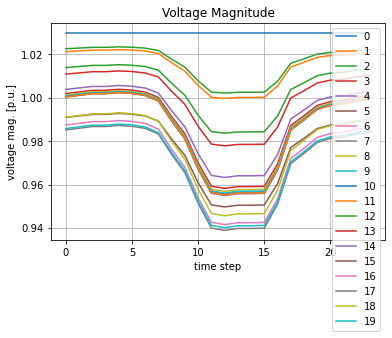

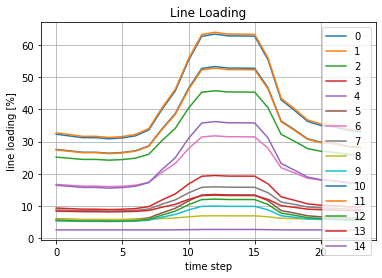

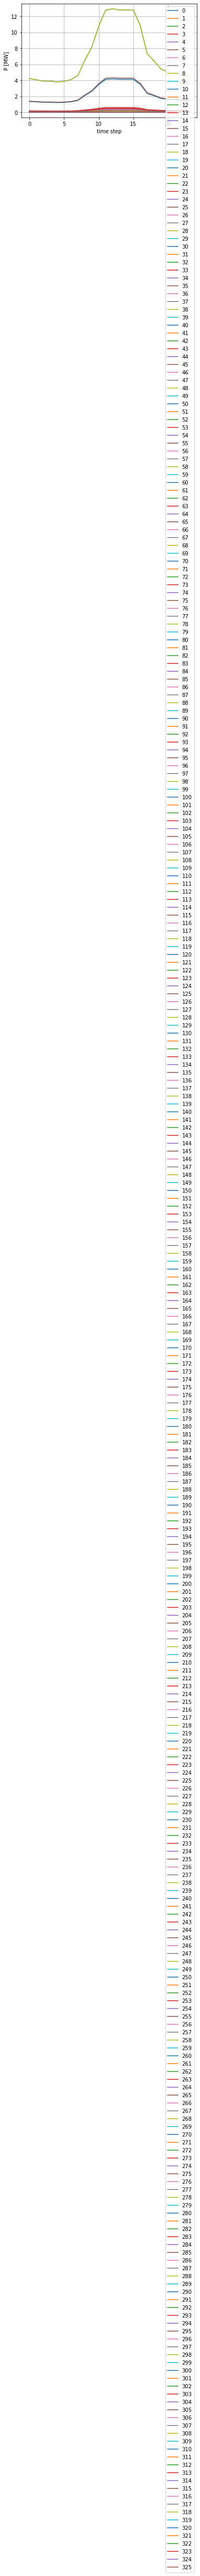

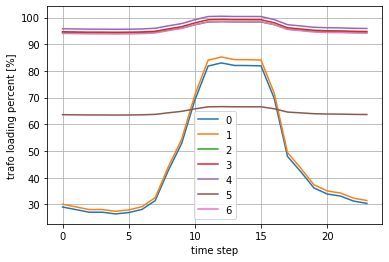

In [100]:
# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

#trafo results
load_file = os.path.join(output_dir, "res_trafo", "loading_percent.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="trafo")
plt.xlabel("time step")
plt.ylabel("trafo loading percent [%]")
plt.grid()
plt.show()

In [101]:
trafo_loading

,0,1,2,3,4,5,6
0,29.005670,30.049718,94.349361,94.682162,95.799621,63.602864,94.044698
1,28.050308,29.074155,94.284830,94.609553,95.725512,63.555041,93.972940
2,27.063458,28.066500,94.218427,94.534838,95.649254,63.505830,93.899100
3,27.058504,28.061442,94.218094,94.534464,95.648872,63.505583,93.898730
4,26.424826,27.414442,94.175592,94.486642,95.600062,63.474084,93.851468
5,26.919394,27.919405,94.208755,94.523956,95.638146,63.498661,93.888344
6,28.111018,29.136147,94.288924,94.614159,95.730213,63.558075,93.977491
7,31.389662,32.484338,94.511454,94.864548,95.985781,63.722986,94.224952
8,42.774760,44.113768,95.307015,95.759812,96.899657,64.312514,95.109797
9,52.812994,54.368916,96.039028,96.583803,97.740918,64.854951,95.924264


In [102]:
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,Load R1,1,4.467702,0.907206,0.0,0.0,15.300,1.0,True,wye
1,Load R3,3,0.082373,0.020645,0.0,0.0,0.285,1.0,True,wye
2,Load R4,4,0.128617,0.032235,0.0,0.0,0.445,1.0,True,wye
3,Load R5,5,0.216770,0.054328,0.0,0.0,0.750,1.0,True,wye
4,Load R6,6,0.163300,0.040927,0.0,0.0,0.565,1.0,True,wye
...,...,...,...,...,...,...,...,...,...,...
321,Vehicle 304,19,0.006600,0.000000,0.0,0.0,NaN,1.0,True,wye
322,Vehicle 305,19,0.006600,0.000000,0.0,0.0,NaN,1.0,True,wye
323,Vehicle 306,19,0.006600,0.000000,0.0,0.0,NaN,1.0,True,wye
324,Vehicle 307,19,0.006600,0.000000,0.0,0.0,NaN,1.0,True,wye


In [87]:
any(vm_pu.min()<0.95)

True

In [78]:
vm_pu.min()

0     1.030000
1     0.999754
2     0.983722
3     0.958312
4     0.955975
5     0.955086
6     0.955107
7     0.955305
8     0.956912
9     0.956116
10    0.955380
11    0.955348
12    1.002148
13    0.977882
14    0.963286
15    0.949172
16    0.941081
17    0.939953
18    0.946595
19    0.946737
dtype: float64

##### 